In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
from lambeq import BobcatParser, AtomicType, IQPAnsatz, remove_cups
from discopy import Ty

In [4]:
data = []
labels = []

with open("./dataset-train.txt") as f:
    for line in f:
        point = line.split(", ")
        data.append((point[0], point[1]))
        labels.append(int(point[2]))

In [5]:
parser = BobcatParser(root_cats=("S"), verbose="text")

data_lists = list(zip(*data))

a = parser.sentences2diagrams(list(data_lists[0]))
b = parser.sentences2diagrams(list(data_lists[1]))

diagrams = list(zip(a, b))

Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.
Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.


In [6]:
for x, y in diagrams:
    assert x.cod == Ty("s") and y.cod == Ty("s")

In [7]:
assert len(data) == len(diagrams)

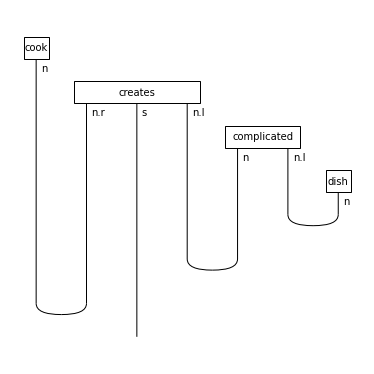

In [8]:
combined = list(zip(diagrams, labels))
train_diagrams = [x[0] for x in combined[:int(len(diagrams) * 0.7)]]
train_labels = [x[1] for x in combined[:int(len(diagrams) * 0.7)]]
val_diagrams = [x[0] for x in combined[int(len(diagrams) * 0.7):int(len(diagrams) * 0.85)]]
val_labels = [x[1] for x in combined[int(len(diagrams) * 0.7):int(len(diagrams) * 0.85)]]
test_diagrams = [x[0] for x in combined[int(len(diagrams) * 0.85):]]
test_labels = [x[1] for x in combined[int(len(diagrams) * 0.85):]]

assert len(data) == len(train_diagrams) + len(val_diagrams) + len(test_diagrams)

train_diagrams[0][0].draw(figsize=(5, 5))

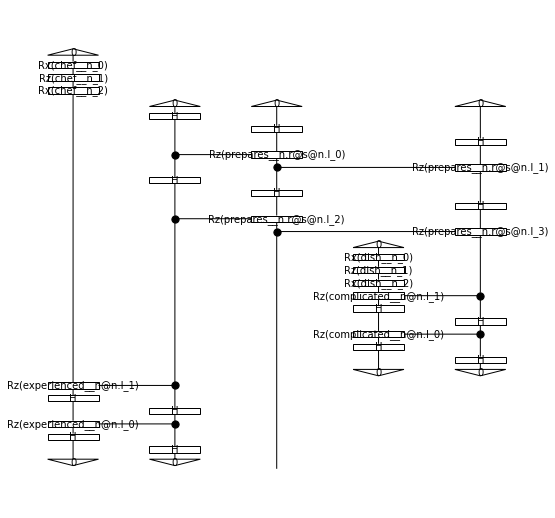

In [9]:
ansatz = IQPAnsatz({AtomicType.NOUN: 1, AtomicType.SENTENCE: 1},
                   n_layers=2, n_single_qubit_params=3)

train_circuits = [(ansatz(remove_cups(d1)), ansatz(remove_cups(d2))) for d1, d2 in train_diagrams]
val_circuits =  [(ansatz(remove_cups(d1)), ansatz(remove_cups(d2))) for d1, d2 in val_diagrams]
test_circuits = [(ansatz(remove_cups(d1)), ansatz(remove_cups(d2))) for d1, d2 in test_diagrams]

train_circuits[0][1].draw(figsize=(7, 7))

In [9]:
from lambeq import NumpyModel
from scipy import spatial

class TupleNumpyModel(NumpyModel):
        def forward(self, x):
            d1, d2 = list(zip(*x))
            o1 = self.get_diagram_output(d1)
            o2 = self.get_diagram_output(d2)
            similarities = []
            for a, b in zip(o1, o2):
                similarities.append(1-spatial.distance.cosine(a, b))
            return np.array(similarities)

In [10]:
all_circuits = [d for p in train_circuits for d in p] + [d for p in val_circuits for d in p]
model = TupleNumpyModel.from_diagrams(all_circuits, use_jit=True)

In [11]:
loss = lambda y_hat, y: np.sum((y_hat-y)**2)  # mean-squared error loss

def acc(y_hat, y):
    pred = y_hat > 0.707    # cosine measure is not symmetric
    return np.sum(pred == y) / len(y)

# acc = lambda y_hat, y: np.sum(np.round(y_hat) == y) / len(y)
eval_metrics = {"acc": acc}

In [12]:
from lambeq import QuantumTrainer, SPSAOptimizer

trainer = QuantumTrainer(
    model,
    loss_function=loss,
    epochs=250,
    optimizer=SPSAOptimizer,
    optim_hyperparams={'a': 0.05, 'c': 0.06, 'A':0.01*200},
    evaluate_functions=eval_metrics,
    evaluate_on_train=True,
    verbose = 'text',
    seed=0
)

In [13]:
from lambeq import Dataset

train_dataset = Dataset(
            train_circuits,
            train_labels,
            batch_size=10)

val_dataset = Dataset(val_circuits, val_labels, shuffle=False)

In [14]:
trainer.fit(train_dataset, val_dataset, evaluation_step=1, logging_step=50)

Epoch 1:    train/loss: 3.7922   valid/loss: 5.7533   train/acc: 0.5286   valid/acc: 0.5333
Epoch 50:   train/loss: 2.5194   valid/loss: 5.3214   train/acc: 0.7000   valid/acc: 0.6667
Epoch 100:  train/loss: 1.5927   valid/loss: 2.9427   train/acc: 0.9000   valid/acc: 0.8667
Epoch 150:  train/loss: 0.6853   valid/loss: 2.7288   train/acc: 0.9857   valid/acc: 0.8667
Epoch 200:  train/loss: 0.5210   valid/loss: 1.3064   train/acc: 0.9857   valid/acc: 0.9333
Epoch 250:  train/loss: 0.5555   valid/loss: 1.5436   train/acc: 0.9857   valid/acc: 0.9333

Training completed!


Test accuracy: 0.9333333333333333


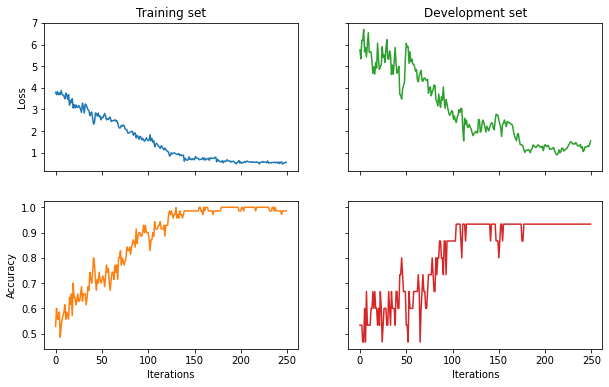

In [15]:
import matplotlib.pyplot as plt

fig, ((ax_tl, ax_tr), (ax_bl, ax_br)) = plt.subplots(2, 2, sharex=True, sharey='row', figsize=(10, 6))
ax_tl.set_title('Training set')
ax_tr.set_title('Development set')
ax_bl.set_xlabel('Iterations')
ax_br.set_xlabel('Iterations')
ax_bl.set_ylabel('Accuracy')
ax_tl.set_ylabel('Loss')

colours = iter(plt.rcParams['axes.prop_cycle'].by_key()['color'])
ax_tl.plot(trainer.train_epoch_costs, color=next(colours))
ax_bl.plot(trainer.train_results['acc'], color=next(colours))
ax_tr.plot(trainer.val_costs, color=next(colours))
ax_br.plot(trainer.val_results['acc'], color=next(colours))

# print test accuracy
test_acc = acc(model(test_circuits), test_labels)
print('Test accuracy:', test_acc.item())

## Test the TketModel

In [16]:
from pytket.extensions.qiskit import AerBackend
from lambeq import TketModel

backend = AerBackend()
backend_config = {
    'backend': backend,
    'compilation': backend.default_compilation_pass(2),
    'shots': 8192
}

class CustomTketModel(TketModel):
    def forward(self, x):
        d1, d2 = list(zip(*x))
        o1 = self.get_diagram_output(d1)
        o2 = self.get_diagram_output(d2)
        similarities = []
        for a, b in zip(o1, o2):
            similarities.append(1-spatial.distance.cosine(a, b))
        return np.array(similarities)

shotbased_model = CustomTketModel.from_diagrams(all_circuits, backend_config=backend_config)

In [17]:
a_new_trainer = QuantumTrainer(
    shotbased_model,
    loss_function=loss,
    epochs=250,
    optimizer=SPSAOptimizer,
    optim_hyperparams={'a': 0.05, 'c': 0.06, 'A':0.01*200},
    evaluate_functions=eval_metrics,
    evaluate_on_train=True,
    verbose = 'text',
    seed=0
)

In [18]:
a_new_trainer.fit(train_dataset, val_dataset, evaluation_step=1, logging_step=50)

Epoch 1:    train/loss: 3.2728   valid/loss: 5.8645   train/acc: 0.6000   valid/acc: 0.5333
Epoch 50:   train/loss: 2.8776   valid/loss: 5.4192   train/acc: 0.6571   valid/acc: 0.5333
Epoch 100:  train/loss: 3.0060   valid/loss: 4.6747   train/acc: 0.5571   valid/acc: 0.6000
Epoch 150:  train/loss: 2.3173   valid/loss: 4.9329   train/acc: 0.7143   valid/acc: 0.6000
Epoch 200:  train/loss: 1.9699   valid/loss: 4.5839   train/acc: 0.7571   valid/acc: 0.6667
Epoch 250:  train/loss: 1.2158   valid/loss: 3.6480   train/acc: 0.8714   valid/acc: 0.7333

Training completed!


Test accuracy: 0.9333333333333333


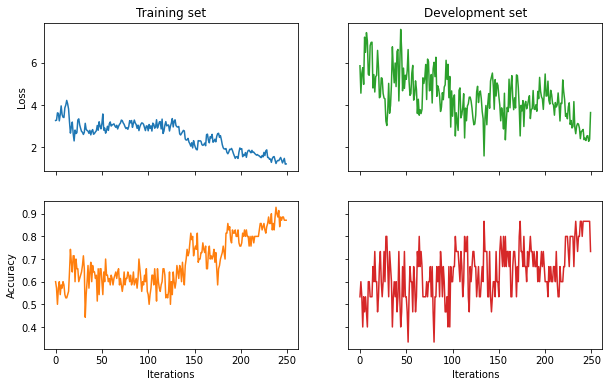

In [19]:
import matplotlib.pyplot as plt

fig, ((ax_tl, ax_tr), (ax_bl, ax_br)) = plt.subplots(2, 2, sharex=True, sharey='row', figsize=(10, 6))
ax_tl.set_title('Training set')
ax_tr.set_title('Development set')
ax_bl.set_xlabel('Iterations')
ax_br.set_xlabel('Iterations')
ax_bl.set_ylabel('Accuracy')
ax_tl.set_ylabel('Loss')

colours = iter(plt.rcParams['axes.prop_cycle'].by_key()['color'])
ax_tl.plot(a_new_trainer.train_epoch_costs, color=next(colours))
ax_bl.plot(a_new_trainer.train_results['acc'], color=next(colours))
ax_tr.plot(a_new_trainer.val_costs, color=next(colours))
ax_br.plot(a_new_trainer.val_results['acc'], color=next(colours))

# print test accuracy
test_acc = acc(model(test_circuits), test_labels)
print('Test accuracy:', test_acc.item())